# Climate Impact Data Analysis

This notebook covers data loading, exploratory data analysis (EDA), and machine learning/clustering modeling using the subnational anomaly statistics dataset.

In [14]:
import pandas as pd

# Load the dataset
# Update the filename if needed
file_path = 'subnational_anomaly_statistics.csv'
df = pd.read_csv(file_path, header=0)

# Inspect the data
print('DataFrame shape:', df.shape)
print('Columns:', df.columns.tolist())
print('Data types:\n', df.dtypes)
print('First 5 rows:\n', df.head())
print('Missing values per column:\n', df.isnull().sum())

DataFrame shape: (2652, 16)
Columns: ['alpha_3', 'ADM0_PCODE', 'ADM0_REF', 'ADM1_PCODE', 'ADM1_REF', 'ADM2_PCODE', 'ADM2_REF', 'ADM3_PCODE', 'ADM3_REF', 'ADM_LEVEL', 'ADM_PCODE', 'ADM_REF', 'Season', 'CHIRPS_mean', 'CHIRPS_min', 'CHIRPS_max']
Data types:
 alpha_3         object
ADM0_PCODE      object
ADM0_REF        object
ADM1_PCODE      object
ADM1_REF        object
ADM2_PCODE      object
ADM2_REF        object
ADM3_PCODE      object
ADM3_REF        object
ADM_LEVEL        int64
ADM_PCODE       object
ADM_REF         object
Season          object
CHIRPS_mean    float64
CHIRPS_min     float64
CHIRPS_max     float64
dtype: object
First 5 rows:
 alpha_3         object
ADM0_PCODE      object
ADM0_REF        object
ADM1_PCODE      object
ADM1_REF        object
ADM2_PCODE      object
ADM2_REF        object
ADM3_PCODE      object
ADM3_REF        object
ADM_LEVEL        int64
ADM_PCODE       object
ADM_REF         object
Season          object
CHIRPS_mean    float64
CHIRPS_min     float64
CH

## Exploratory Data Analysis (EDA)

In this section, we will explore the dataset, generate descriptive statistics, and visualize distributions and relationships among variables.

In [15]:
# Select numeric columns for EDA
numeric_cols = df.select_dtypes(include='number')

# Summary statistics
print('Summary statistics:\n', numeric_cols.describe())
print('Median:\n', numeric_cols.median())
mode_df = numeric_cols.mode()
if not mode_df.empty:
    print('Mode:\n', mode_df.iloc[0])
else:
    print('Mode: No mode found (empty DataFrame)')
print('Standard Deviation:\n', numeric_cols.std())

# Outlier detection using IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).sum()
print('Outliers per column:\n', outliers)

Summary statistics:
          ADM_LEVEL  CHIRPS_mean   CHIRPS_min   CHIRPS_max
count  2652.000000  2374.000000  2374.000000  2374.000000
mean      2.757164    69.393682    32.413554   113.413558
std       0.549206   110.969599    91.723023   149.733451
min       1.000000  -148.057500  -284.243870  -148.057500
25%       3.000000    -7.950622   -24.138707     5.241953
50%       3.000000    29.688690     5.221055    64.465910
75%       3.000000   125.430828    75.277535   182.481300
max       3.000000   837.377250   544.821410  1502.786380
Median:
 ADM_LEVEL       3.000000
CHIRPS_mean    29.688690
CHIRPS_min      5.221055
CHIRPS_max     64.465910
dtype: float64
Median:
 ADM_LEVEL       3.000000
CHIRPS_mean    29.688690
CHIRPS_min      5.221055
CHIRPS_max     64.465910
dtype: float64
Mode:
 ADM_LEVEL        3.00000
CHIRPS_mean    -24.41809
CHIRPS_min    -154.05301
CHIRPS_max     -11.40930
Name: 0, dtype: float64
Standard Deviation:
 ADM_LEVEL        0.549206
CHIRPS_mean    110.969599
CHIRP

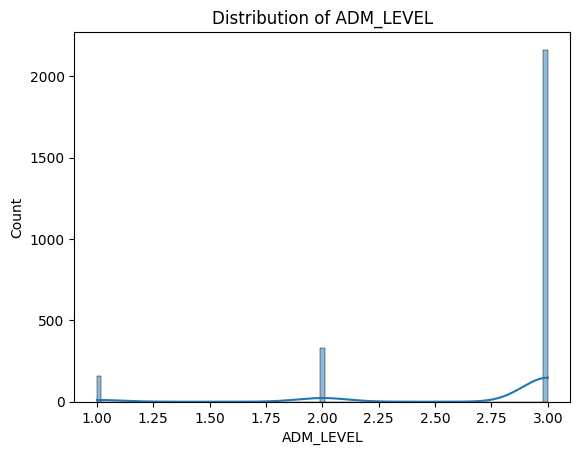

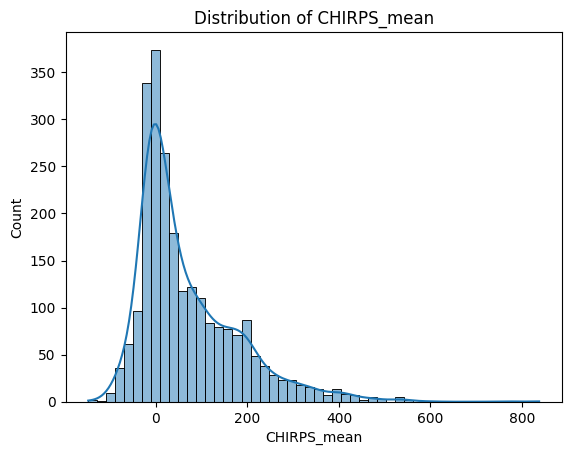

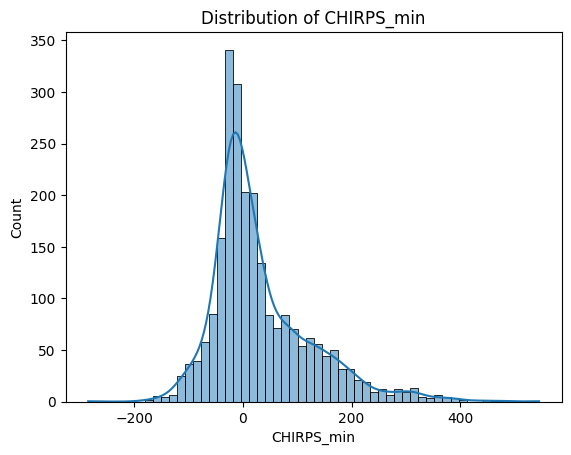

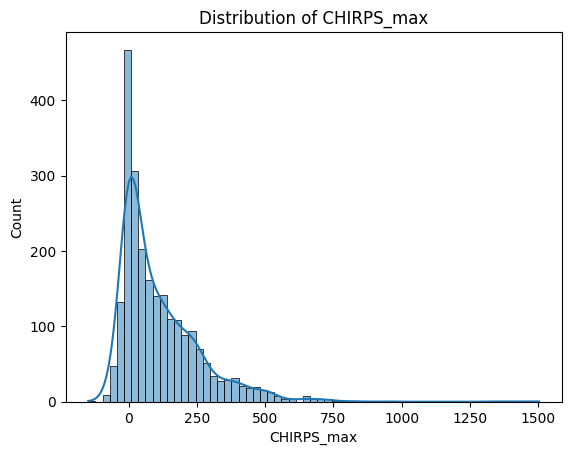

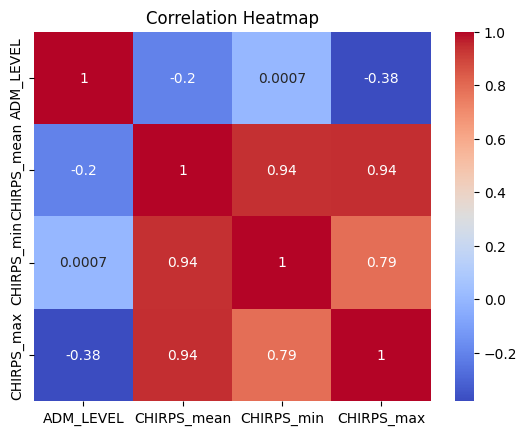

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for all valid numeric columns
for col in numeric_cols.columns:
    if numeric_cols[col].dropna().empty:
        print(f"Column '{col}' is empty or all NaN, skipping plot.")
        continue
    sns.histplot(numeric_cols[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Correlation heatmap
if numeric_cols.shape[1] > 1:
    corr = numeric_cols.corr()
    if not corr.isnull().all().all():
        sns.heatmap(corr, annot=True, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.show()
    else:
        print("Correlation matrix is empty or all NaN.")
else:
    print("Not enough numeric columns for correlation heatmap.")

## Machine Learning & Clustering

In this section, we will apply a clustering model (KMeans) to the numeric features and visualize the results.

Cluster
0.0    1498
2.0     679
1.0     197
Name: count, dtype: int64


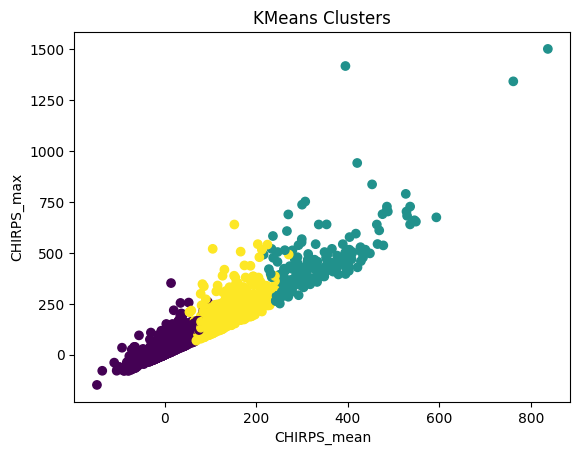

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select numeric features for clustering
features = ['CHIRPS_mean', 'CHIRPS_min', 'CHIRPS_max']
X = df[features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df.loc[X.index, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Show cluster counts
print(df['Cluster'].value_counts())

# Visualize clusters (using first two features)
import matplotlib.pyplot as plt
plt.scatter(X['CHIRPS_mean'], X['CHIRPS_max'], c=df.loc[X.index, 'Cluster'], cmap='viridis')
plt.xlabel('CHIRPS_mean')
plt.ylabel('CHIRPS_max')
plt.title('KMeans Clusters')
plt.show()

## Model Evaluation & Innovation

In this section, we will evaluate the clustering model using the silhouette score and add a custom function for cluster analysis.

In [18]:
from sklearn.metrics import silhouette_score

# Evaluate clustering with silhouette score
score = silhouette_score(X_scaled, df.loc[X.index, 'Cluster'])
print(f'Silhouette Score: {score:.3f}')

# Custom function: summary statistics by cluster
def cluster_summary(df, features, cluster_col='Cluster'):
    return df.groupby(cluster_col)[features].describe()

print('Cluster Summary Statistics:')
print(cluster_summary(df.loc[X.index], features))

Silhouette Score: 0.564
Cluster Summary Statistics:
        CHIRPS_mean                                                            \
              count        mean        std        min         25%         50%   
Cluster                                                                         
0.0          1498.0    1.533832  34.341795 -148.05750  -17.794393   -1.396235   
1.0           197.0  334.206762  91.753160  216.16999  266.614630  310.247800   
2.0           679.0  142.274211  46.824908   54.03004  100.095885  139.472000   

                               CHIRPS_min              ...              \
                75%        max      count        mean  ...         75%   
Cluster                                                ...               
0.0       24.461982   99.70520     1498.0  -20.412367  ...    2.114397   
1.0      380.132380  837.37725      197.0  231.802484  ...  292.756410   
2.0      182.977300  270.98382      679.0   91.108121  ...  131.768045   

                

## Summary & Next Steps

- Data loaded and inspected
- EDA performed with statistics and visualizations
- KMeans clustering applied and visualized
- Model evaluated with silhouette score
- Cluster summary statistics generated

You can now further analyze clusters, try classification/regression, or export results for reporting.

In [ ]:
# Rename columns for Power BI compatibility
df_renamed = df.rename(columns={
    'alpha_3': 'Country_Code',
    'ADM_LEVEL': 'Admin_Level',
    'ADM_PCODE': 'Admin_PCode',
    'ADM_REF': 'Admin_Ref',
    'ADM0_PCODE': 'Admin0_PCode',
    'ADM0_REF': 'Admin0_Ref',
    'ADM1_PCODE': 'Admin1_PCode',
    'ADM1_REF': 'Admin1_Ref',
    'ADM2_PCODE': 'Admin2_PCode',
    'ADM2_REF': 'Admin2_Ref',
    'ADM3_PCODE': 'Admin3_PCode',
    'ADM3_REF': 'Admin3_Ref',
    'CHIRPS_max': 'Rainfall_Max',
    'CHIRPS_mean': 'Rainfall_Mean',
    'CHIRPS_min': 'Rainfall_Min',
    'Season': 'Season',
    'Cluster': 'Cluster'
})

# Export the renamed DataFrame to CSV for Power BI
df_renamed.to_csv('subnational_anomaly_statistics_with_clusters_renamed.csv', index=False, encoding='utf-8')
print('Exported CSV with renamed columns for Power BI.')